#Data_Set : Hotel/Resort Customer Reviews

In [156]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.linear_model import LinearRegression

In [157]:
# Download NLTK stopwords if not already present
nltk.download('stopwords')
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saikrishna_gajula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
# Load the data
df = pd.read_csv('Data Analyst - Test.csv')

In [159]:
def parse_dates(date_str):
    if '/' in date_str:  # Check for 'YYYY/MM/DD' format
        return pd.to_datetime(date_str, format='%Y/%m/%d', errors='coerce')
    else:  # Handle 'Month Year' format
        return pd.to_datetime(date_str, format='%b %Y', errors='coerce')

# Apply the custom date parser
df['date'] = df['date'].apply(parse_dates)

# Check for any NaT values after parsing dates
if df['date'].isna().any():
    print("Warning: Some dates could not be parsed and are set to NaT.")

In [160]:
# Insight 1: Location Distribution Analysis
def analyze_location_distribution(df, top_n=10):
    """Analyzes and visualizes the distribution of reviews by location."""
    # Count occurrences of each location
    location_counts = df['Location'].value_counts().head(top_n)
    
    # Create a horizontal bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.barh(location_counts.index, location_counts.values, color='skyblue')
    
    # Add data labels
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                 f'{bar.get_width()}', va='center', ha='left', fontsize=10)

    # Enhance the plot's aesthetics
    plt.title('Top Review Distribution by Location', fontsize=16)
    plt.xlabel('Number of Reviews', fontsize=14)
    plt.ylabel('Location', fontsize=14)
    plt.xlim(0, location_counts.max() + 5) 
    plt.tight_layout()
    plt.savefig('location_distribution.png')
    plt.show() 
    return location_counts


In [161]:
# Insight 2: Temporal Analysis
def temporal_analysis(df, frequency='M'):
    """Analyzes and visualizes the distribution of reviews over time, aggregated by month or week."""
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Group by the specified frequency (monthly or weekly)
    date_counts = df.resample(frequency, on='date').size()

    # Calculate a moving average (for smoothing)
    moving_average = date_counts.rolling(window=3).mean()  # 3-period moving average

    # Create a line plot with moving average
    plt.figure(figsize=(12, 6))
    plt.plot(date_counts.index, date_counts, label='Daily Reviews', color='cyan', alpha=0.5)
    plt.plot(moving_average.index, moving_average, label='Moving Average (3 periods)', color='blue', linewidth=2)

    # Enhance the plot's aesthetics
    plt.title('Reviews Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Reviews', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temporal_analysis.png')
    plt.show()  # Display the plot
    return date_counts


In [162]:
# Insight 3: Sentiment Analysis
def perform_sentiment_analysis(df):
    """Performs sentiment analysis by counting positive and negative keywords."""
    positive_keywords = ['great', 'loved', 'excellent', 'nice', 'clean', 'comfortable', 'friendly']
    negative_keywords = ['old', 'musty', 'small', 'needs work', 'thin', 'poor', 'unresponsive']
    
    def count_sentiment_keywords(review):
        # Check if review is a string before processing
        if isinstance(review, str):
            review = review.lower()
            pos_count = sum(keyword in review for keyword in positive_keywords)
            neg_count = sum(keyword in review for keyword in negative_keywords)
            return pos_count, neg_count
        else:
            return 0, 0  # Handle non-string cases
    
    # Fill NaN values with empty string and apply the sentiment counting function
    df[['positive_count', 'negative_count']] = df['Review'].fillna('').apply(
        lambda x: pd.Series(count_sentiment_keywords(x))
    )

    # Set up the aesthetics for the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    # Use a hexbin plot for better density visualization
    plt.hexbin(df['positive_count'], df['negative_count'], gridsize=30, cmap='Blues', mincnt=1)
    
    # Fit a linear regression model to plot a trend line
    X = df['positive_count'].values.reshape(-1, 1)
    y = df['negative_count'].values
    reg = LinearRegression().fit(X, y)
    plt.plot(df['positive_count'], reg.predict(X), color='red', linewidth=2, label='Trend Line')

    # Add titles and labels
    plt.title('Sentiment Analysis: Positive vs Negative Keywords', fontsize=16)
    plt.xlabel('Positive Keyword Count', fontsize=14)
    plt.ylabel('Negative Keyword Count', fontsize=14)
    plt.colorbar(label='Density')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('sentiment_analysis_hexbin.png')
    plt.show()  # Show the plot for immediate feedback
    return df[['positive_count', 'negative_count']]


In [163]:
# Insight 4: Review Length Analysis
def analyze_review_length(df):
    """Analyzes and visualizes the length of reviews."""
    df['review_length'] = df['Review'].str.len()
    plt.figure(figsize=(10, 6))
    df['review_length'].plot(kind='hist', bins=20)
    plt.title('Distribution of Review Lengths')
    plt.xlabel('Review Length (characters)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('review_length_distribution.png')
    return df['review_length']

In [164]:
# Insight 5: Keyword Frequency Analysis
def analyze_keyword_frequency(df):
    """Analyzes and visualizes the frequency of keywords in reviews."""
    all_reviews = ' '.join(df['Review'].fillna(''))
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\w+', all_reviews.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    word_freq = Counter(filtered_words)
    top_words = word_freq.most_common(15)
    
    plt.figure(figsize=(12, 6))
    plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
    plt.title('Top 15 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('keyword_frequency.png')
    return dict(top_words)

In [165]:
# New Insight: Polarity and Subjectivity Analysis
def analyze_polarity_subjectivity(df):
    """Analyzes the polarity and subjectivity of reviews."""
    
    # Ensure that all reviews are strings
    df['Review'] = df['Review'].fillna('').astype(str)
    
    df['polarity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['polarity'], kde=True, bins=20, color='blue')
    plt.title('Polarity Distribution of Reviews')
    plt.xlabel('Polarity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('polarity_distribution.png')
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['subjectivity'], kde=True, bins=20, color='green')
    plt.title('Subjectivity Distribution of Reviews')
    plt.xlabel('Subjectivity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('subjectivity_distribution.png')
    
    return df[['polarity', 'subjectivity']]

In [166]:
# New Insight: Word Cloud Generation
def generate_word_cloud(df, sentiment='positive'):
    """Generates a word cloud for positive or negative reviews."""
    if sentiment == 'positive':
        reviews = ' '.join(df[df['positive_count'] > df['negative_count']]['Review'].fillna(''))
    else:
        reviews = ' '.join(df[df['negative_count'] > df['positive_count']]['Review'].fillna(''))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} Review Word Cloud')
    plt.tight_layout()
    plt.savefig(f'{sentiment}_word_cloud.png')
    plt.show()

In [167]:
# Main Analysis Function
def comprehensive_hotel_review_analysis(df):
    """Performs a comprehensive analysis of hotel reviews."""
    results = {
        'Location Distribution': analyze_location_distribution(df),
        'Temporal Analysis': temporal_analysis(df),
        'Sentiment Analysis': perform_sentiment_analysis(df),
        'Review Length': analyze_review_length(df),
        'Keyword Frequency': analyze_keyword_frequency(df),
        'Polarity and Subjectivity': analyze_polarity_subjectivity(df)
    }
    
    # Generate word clouds for visual insights
    generate_word_cloud(df, 'positive')
    generate_word_cloud(df, 'negative')
    
    return results

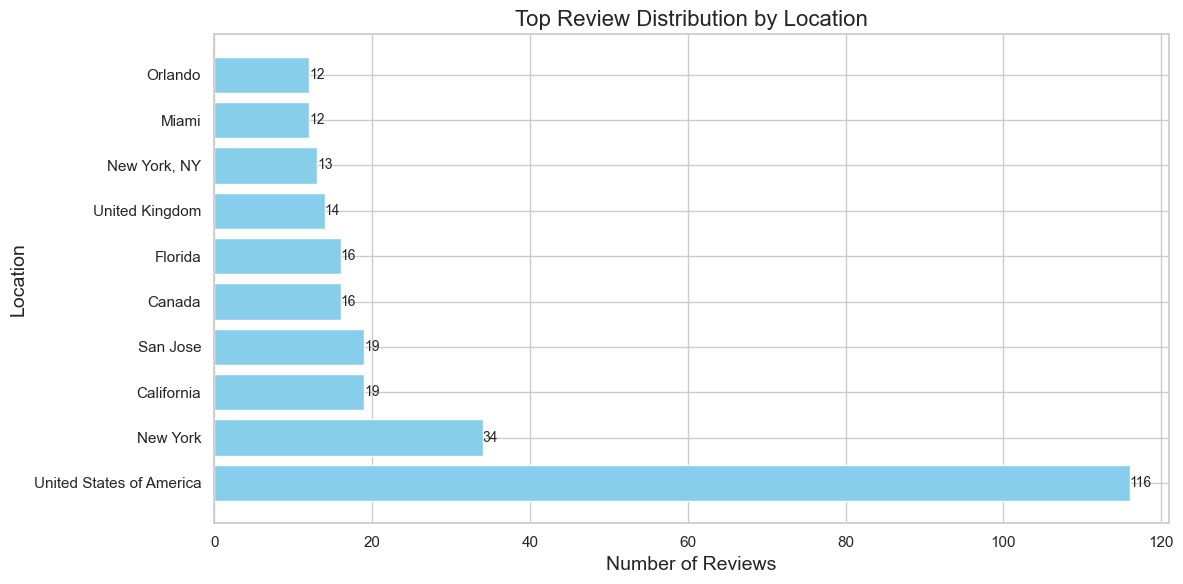

/var/folders/52/dr9tscs95_37928gzg06xct00000gq/T/ipykernel_66159/486261645.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_counts = df.resample(frequency, on='date').size()


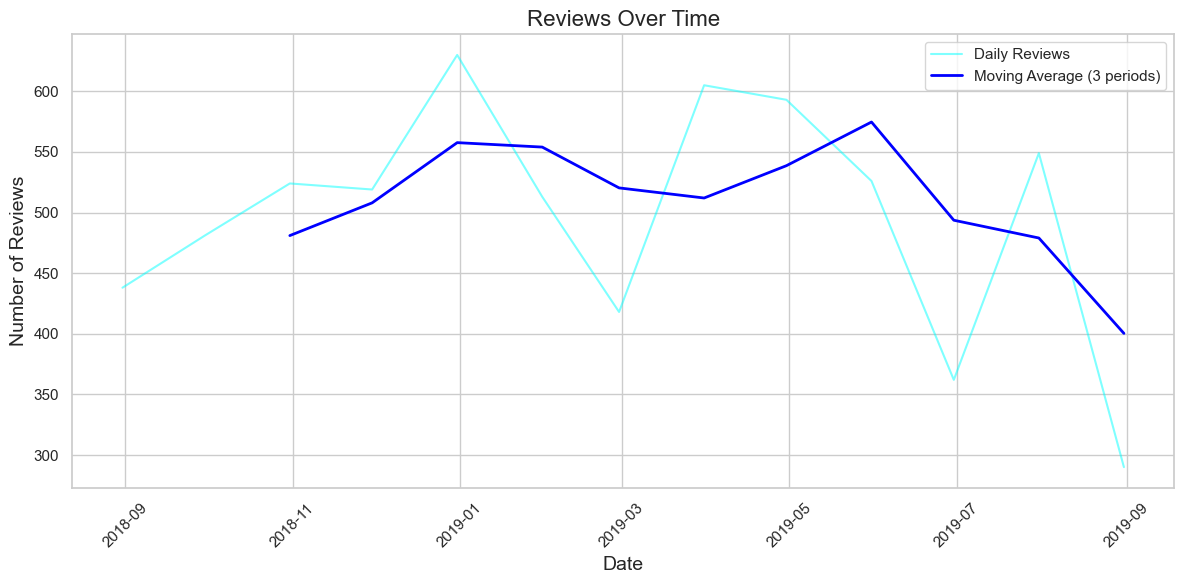

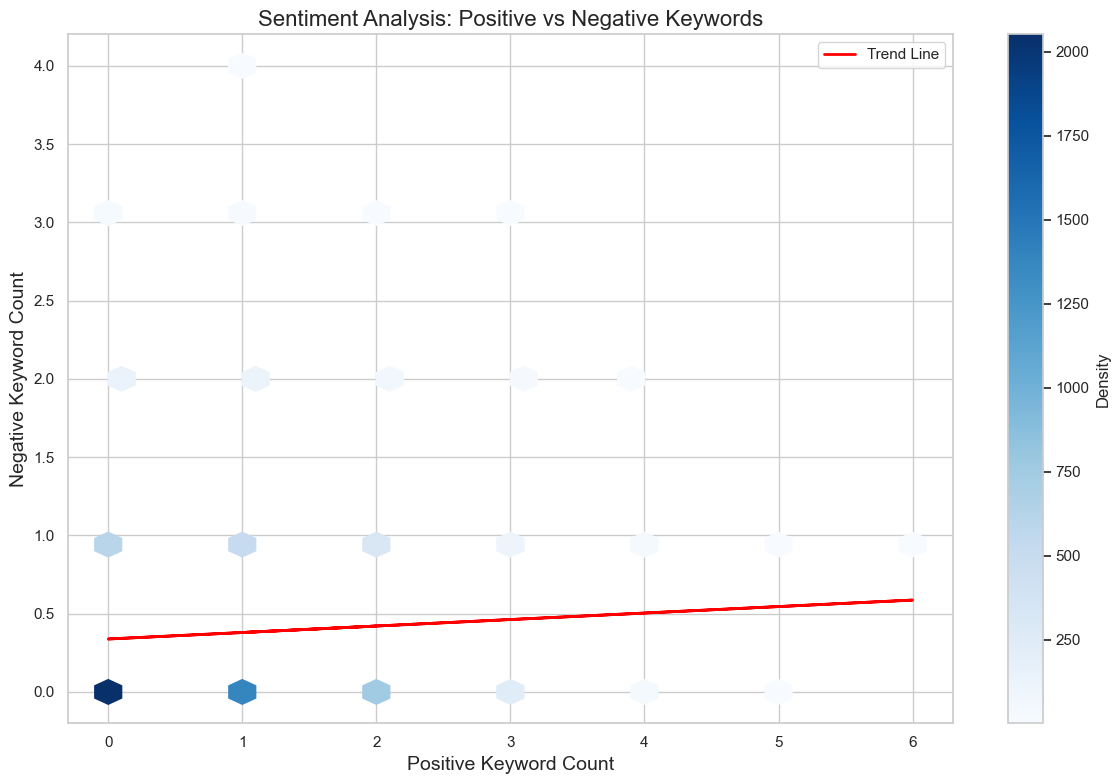

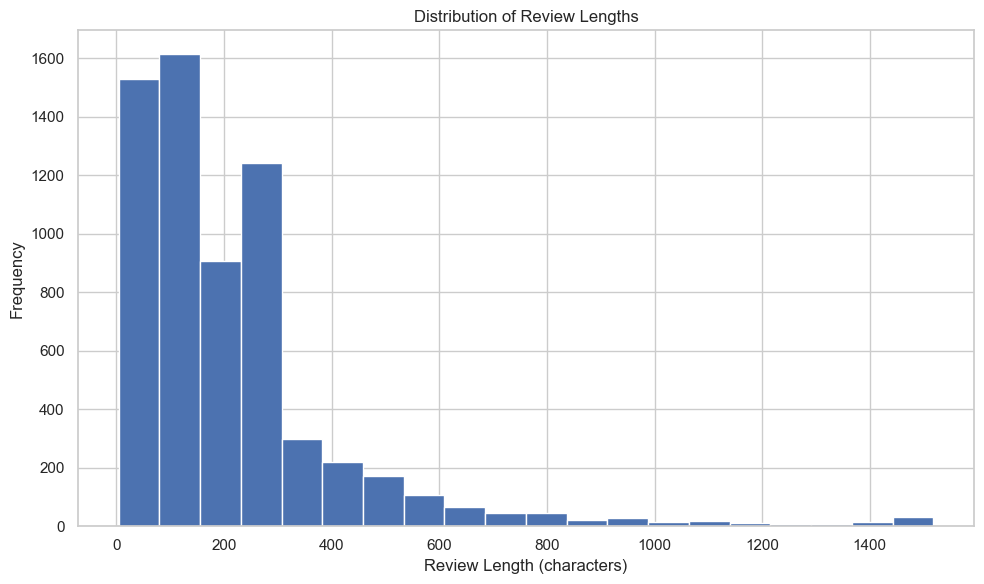

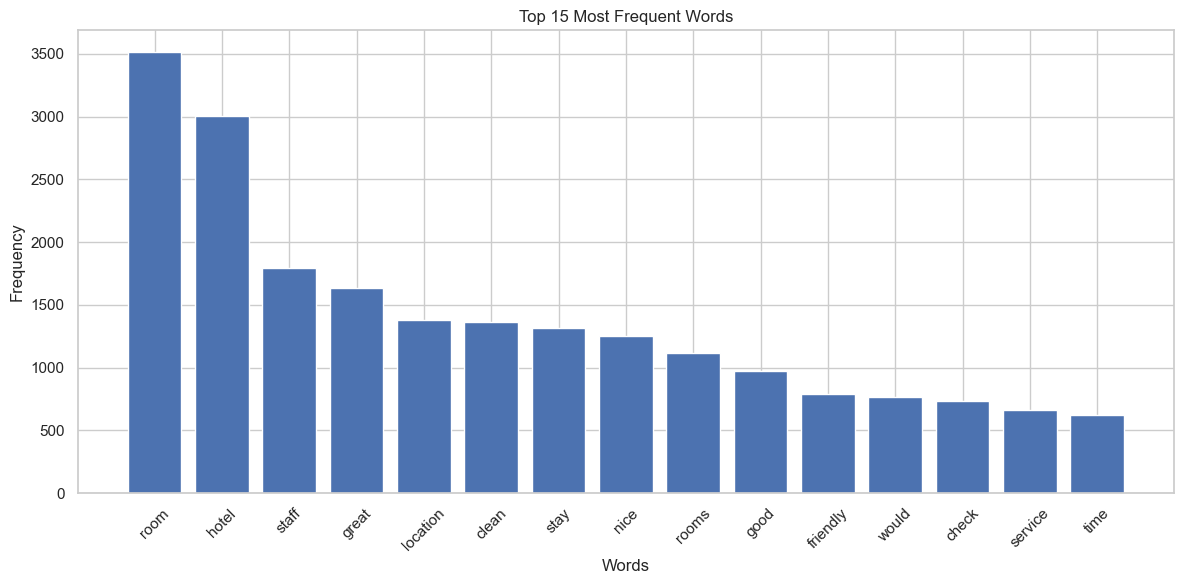

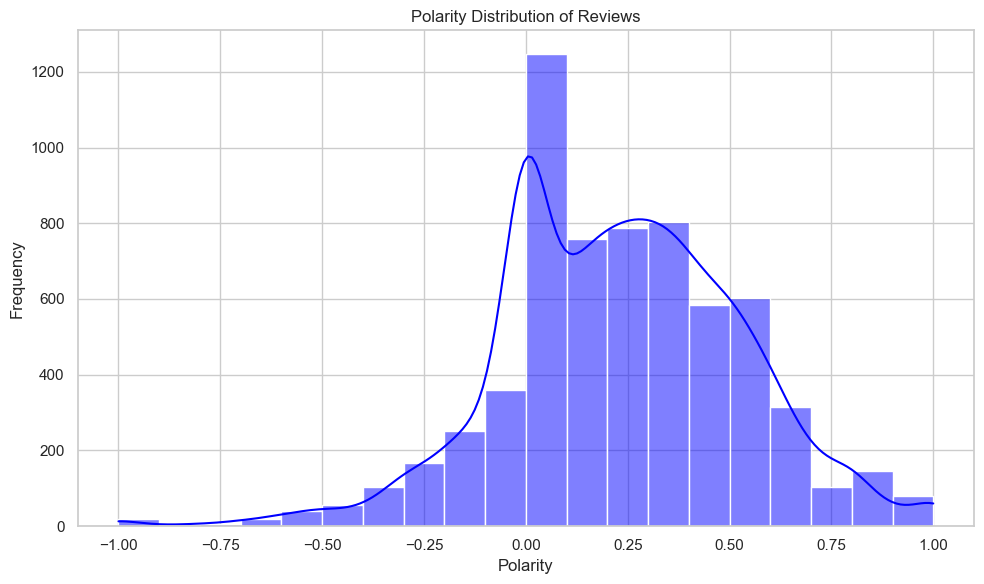

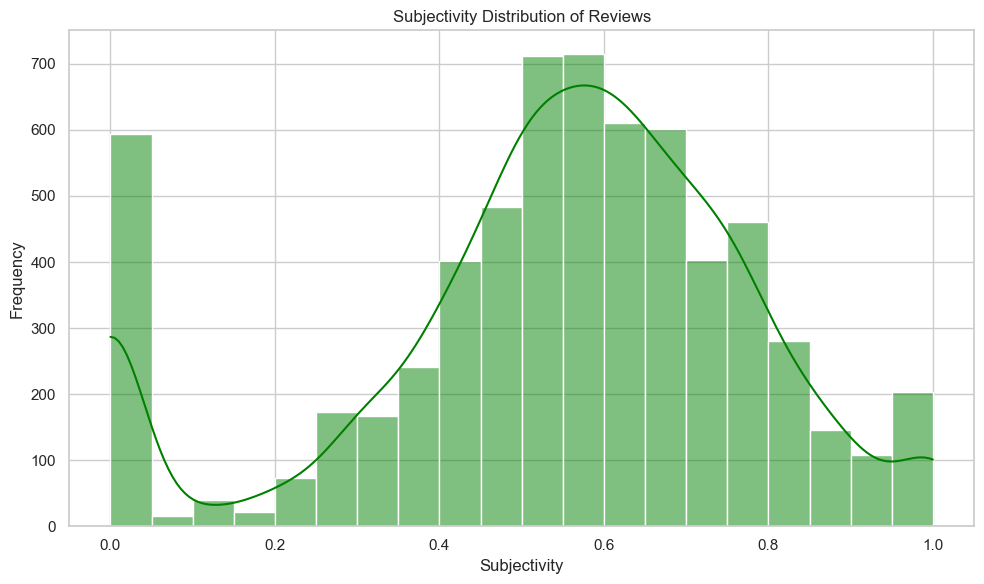

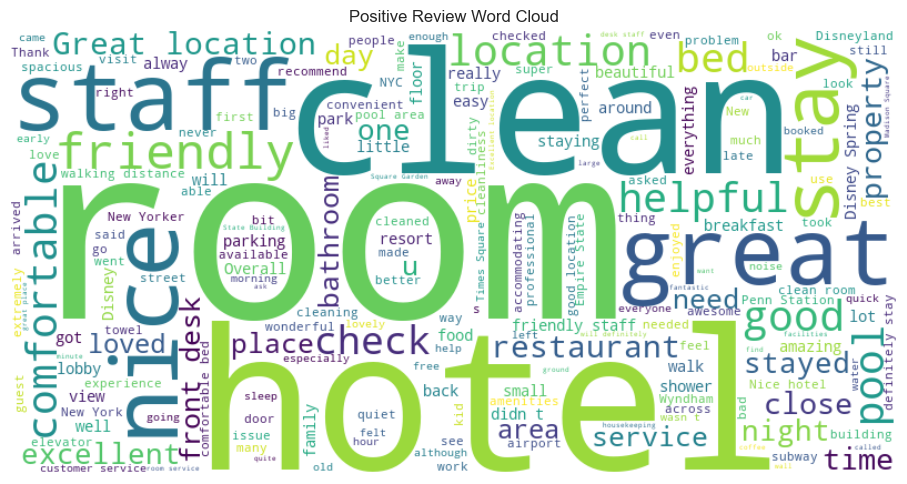

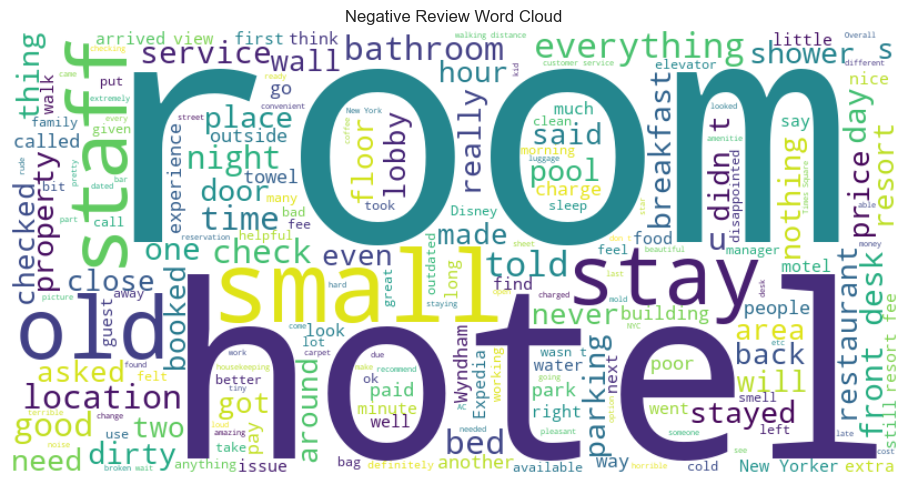

Analysis Complete. Check the generated visualizations!

Location Distribution:
Location
United States of America    116
New York                     34
California                   19
San Jose                     19
Canada                       16
Florida                      16
United Kingdom               14
New York, NY                 13
Miami                        12
Orlando                      12
Name: count, dtype: int64

Temporal Analysis:
date
2018-08-31    438
2018-09-30    481
2018-10-31    524
2018-11-30    519
2018-12-31    630
2019-01-31    513
2019-02-28    418
2019-03-31    605
2019-04-30    593
2019-05-31    526
2019-06-30    362
2019-07-31    549
2019-08-31    290
Freq: ME, dtype: int64

Sentiment Analysis:
      positive_count  negative_count
0                  2               0
1                  1               1
2                  1               0
3                  1               2
4                  2               0
...              ...             ...
6443

In [168]:
# Run the analysis
analysis_results = comprehensive_hotel_review_analysis(df)

# Print out key findings
print("Analysis Complete. Check the generated visualizations!")
for key, value in analysis_results.items():
    print(f"\n{key}:")
    print(value)